In [1]:
import tensorflow as tf
import numpy as np
import os
%matplotlib inline

In [2]:
os.listdir('../input/city-scape/leftimg8bit_trainvaltest/leftImg8bit')

['train', 'val', 'test']

In [3]:
os.listdir('../input/city-scape/gtfine_trainvaltest/gtFine/train/aachen')[:5]

['aachen_000034_000019_gtFine_labelIds.png',
 'aachen_000023_000019_gtFine_color.png',
 'aachen_000038_000019_gtFine_color.png',
 'aachen_000064_000019_gtFine_color.png',
 'aachen_000121_000019_gtFine_labelIds.png']

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
images = tf.io.gfile.glob(
    "gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/*/*.png")

In [6]:
len(images)

2975

In [7]:
images[:5]

['gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000001_000019_leftImg8bit.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000002_000019_leftImg8bit.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000003_000019_leftImg8bit.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000004_000019_leftImg8bit.png']

In [8]:
annotations = tf.io.gfile.glob(
    "gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/*/*_gtFine_labelIds.png")

In [9]:
len(annotations)

2975

In [10]:
annotations[:5]

['gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/aachen/aachen_000001_000019_gtFine_labelIds.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/aachen/aachen_000002_000019_gtFine_labelIds.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/aachen/aachen_000003_000019_gtFine_labelIds.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/aachen/aachen_000004_000019_gtFine_labelIds.png']

In [11]:
images.sort(key=lambda x:x.split('train/')[-1].split('_leftImg8bit.png')[0])
annotations.sort(key=lambda x:x.split('train/')[-1].split('_gtFine_labelIds.png')[0])

In [12]:
images[:5]

['gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000001_000019_leftImg8bit.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000002_000019_leftImg8bit.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000003_000019_leftImg8bit.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000004_000019_leftImg8bit.png']

In [13]:
annotations[:5]

['gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/aachen/aachen_000001_000019_gtFine_labelIds.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/aachen/aachen_000002_000019_gtFine_labelIds.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/aachen/aachen_000003_000019_gtFine_labelIds.png',
 'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/aachen/aachen_000004_000019_gtFine_labelIds.png']

In [14]:
annotations[1005]

'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/dusseldorf/dusseldorf_000180_000019_gtFine_labelIds.png'

In [15]:
images[1005]

'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/dusseldorf/dusseldorf_000180_000019_leftImg8bit.png'

In [16]:
img = tf.io.read_file(annotations[536])
img = tf.image.decode_png(img, channels=1)

In [17]:
np.unique(img)

array([ 1,  3,  4,  5,  6,  7,  8,  9, 11, 13, 17, 19, 20, 21, 22, 23, 24,
       26], dtype=uint8)

In [18]:
train_count = len(images)
len(images), len(annotations)

(2975, 2975)

In [19]:
np.random.seed(2019)
index = np.random.permutation(len(images))

In [20]:
images = np.array(images)[index]

In [21]:
images[:5]

array(['gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/bremen/bremen_000045_000019_leftImg8bit.png',
       'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/ulm/ulm_000071_000019_leftImg8bit.png',
       'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/weimar/weimar_000042_000019_leftImg8bit.png',
       'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/jena/jena_000043_000019_leftImg8bit.png',
       'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/train/bremen/bremen_000046_000019_leftImg8bit.png'],
      dtype='<U170')

In [22]:
anno = np.array(annotations)[index]

In [23]:
anno[:5]

array(['gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/bremen/bremen_000045_000019_gtFine_labelIds.png',
       'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/ulm/ulm_000071_000019_gtFine_labelIds.png',
       'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/weimar/weimar_000042_000019_gtFine_labelIds.png',
       'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/jena/jena_000043_000019_gtFine_labelIds.png',
       'gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/train/bremen/bremen_000046_000019_gtFine_labelIds.png'],
      dtype='<U164')

In [24]:
dataset_train = tf.data.Dataset.from_tensor_slices((images, anno))

In [25]:
images_val = tf.io.gfile.glob(
    "gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/leftimg8bit_trainvaltest/leftImg8bit/val/*/*.png")
annotations_val = tf.io.gfile.glob(
    "gs://kds-aa957674c298f819a5483966a7efaee584a2dddcc4fab3b42823227f/gtfine_trainvaltest/gtFine/val/*/*_gtFine_labelIds.png")

In [26]:
val_count = len(images_val)
len(images_val), len(annotations_val)

(500, 500)

In [27]:
dataset_val = tf.data.Dataset.from_tensor_slices((images_val, annotations_val))

In [28]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img

In [29]:
def read_png_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    return img

In [30]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/127.5 - 1
    input_mask = tf.cast(input_mask, tf.int32)
    return input_image, input_mask

In [31]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [32]:
def random_crop(img, mask):
    concat_img = tf.concat([img, mask], axis=-1)
    concat_img = tf.image.resize(concat_img, (280, 280),
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img = tf.image.random_crop(concat_img, [256, 256, 4])
    return crop_img[ :, :, :3], crop_img[ :, :, 3:]

In [33]:
def load_image_train(input_image_path, input_mask_path):
    input_image = read_png(input_image_path)
    input_mask = read_png_label(input_mask_path)
    
    input_image, input_mask = random_crop(input_image, input_mask)
#    input_image = tf.image.resize(input_image, [256, 256])
#    input_mask = tf.image.resize(input_mask, [256, 256])
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [34]:
def load_image_val(input_image_path, input_mask_path):
    input_image = read_png(input_image_path)
    input_mask = read_png_label(input_mask_path)
    input_image = tf.image.resize(input_image, (IMG_HEIGHT, IMG_WIDTH))
    input_mask = tf.image.resize(input_mask, (IMG_HEIGHT, IMG_WIDTH))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [35]:
#BATCH_SIZE = 8 * tpu_strategy.num_replicas_in_sync
BATCH_SIZE = 32
BUFFER_SIZE = 300
STEPS_PER_EPOCH = train_count // BATCH_SIZE
VALIDATION_STEPS = val_count // BATCH_SIZE

In [36]:
AUTO = tf.data.experimental.AUTOTUNE

In [37]:
dataset_train = dataset_train.map(load_image_train, num_parallel_calls=AUTO)
dataset_val = dataset_val.map(load_image_val, num_parallel_calls=AUTO)

In [38]:
dataset_train = dataset_train.cache().repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)
dataset_val = dataset_val.cache().batch(BATCH_SIZE)

ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

In [39]:
dataset_train

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>

In [40]:
dataset_val

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>

for img, musk in train_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(musk[0]))

In [41]:
OUTPUT_CHANNELS = 34

In [42]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)     #  256*256*64
    
    x1 = tf.keras.layers.MaxPooling2D(padding='same')(x)   # 128*128*64
    
    x1 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)     
    x1 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)     #  128*128*128
    
    x2 = tf.keras.layers.MaxPooling2D(padding='same')(x1)   # 64*64*128
    
    x2 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)     
    x2 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)     #  64*64*256
    
    x3 = tf.keras.layers.MaxPooling2D(padding='same')(x2)   # 32*32*256
    
    x3 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)     
    x3 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)     #  32*32*512
    
    x4 = tf.keras.layers.MaxPooling2D(padding='same')(x3)   # 16*16*512
    
    x4 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)     
    x4 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)     #  16*16*1024
    
    #  上采样部分
    
    x5 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2,
                                         padding='same', activation='relu')(x4) 
    x5 = tf.keras.layers.BatchNormalization()(x5)     #  32*32*512
    
    x6 = tf.concat([x3, x5], axis=-1)  #  32*32*1024
    
    x6 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)     
    x6 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)     #  32*32*512
    
    x7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2,
                                         padding='same', activation='relu')(x6) 
    x7 = tf.keras.layers.BatchNormalization()(x7)     #  64*64*256
    
    x8 = tf.concat([x2, x7], axis=-1)  #  64*64*512
    
    x8 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)     
    x8 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)     #  64*64*256
    
    x9 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2,
                                         padding='same', activation='relu')(x8) 
    x9 = tf.keras.layers.BatchNormalization()(x9)     #  128*128*128
    
    x10 = tf.concat([x1, x9], axis=-1)  #  128*128*256
    
    x10 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)     
    x10 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)     #  128*128*128
    
    x11 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2,
                                         padding='same', activation='relu')(x10) 
    x11 = tf.keras.layers.BatchNormalization()(x11)     #  256*256*64
    
    x12 = tf.concat([x, x11], axis=-1)  #  256*256*128
    
    x12 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)     
    x12 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)     #  256*256*64
    
    output = tf.keras.layers.Conv2D(34, 1, padding='same', activation='softmax')(x12)
    #  256*256*34
    return tf.keras.Model(inputs=inputs, outputs=output)

In [43]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

In [44]:
model = create_model()
model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001), 
        loss='sparse_categorical_crossentropy',
        metrics=['acc', MeanIoU(num_classes=34)])

In [45]:
EPOCHS = 60

In [46]:
history = model.fit(dataset_train, 
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=dataset_val,)
#                    callbacks=[lr_callback],)

Train for 92 steps, validate for 15 steps
Epoch 1/60
92/92 [==============================] - 1300s 14s/step - loss: 1.2754 - acc: 0.6846 - mean_io_u: 0.1038 - val_loss: 8.9499 - val_acc: 0.0658 - val_mean_io_u: 0.0028
Epoch 2/60
92/92 [==============================] - 90s 980ms/step - loss: 0.8575 - acc: 0.7648 - mean_io_u: 0.1386 - val_loss: 6.4838 - val_acc: 0.3424 - val_mean_io_u: 0.0229
Epoch 3/60
92/92 [==============================] - 88s 954ms/step - loss: 0.7475 - acc: 0.7930 - mean_io_u: 0.1559 - val_loss: 7.0688 - val_acc: 0.2384 - val_mean_io_u: 0.0233
Epoch 4/60
92/92 [==============================] - 88s 954ms/step - loss: 0.6960 - acc: 0.8078 - mean_io_u: 0.1733 - val_loss: 7.0452 - val_acc: 0.2045 - val_mean_io_u: 0.0199
Epoch 5/60
92/92 [==============================] - 88s 954ms/step - loss: 0.6499 - acc: 0.8196 - mean_io_u: 0.1882 - val_loss: 2.4464 - val_acc: 0.4248 - val_mean_io_u: 0.0681
Epoch 6/60
92/92 [==============================] - 88s 954ms/step - loss

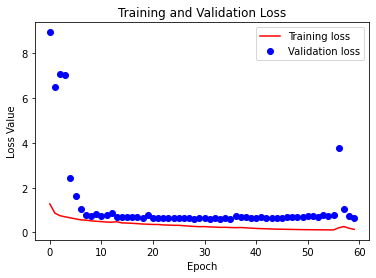

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
#plt.ylim([0, 1])
plt.legend()
plt.show()

In [48]:
num = 3

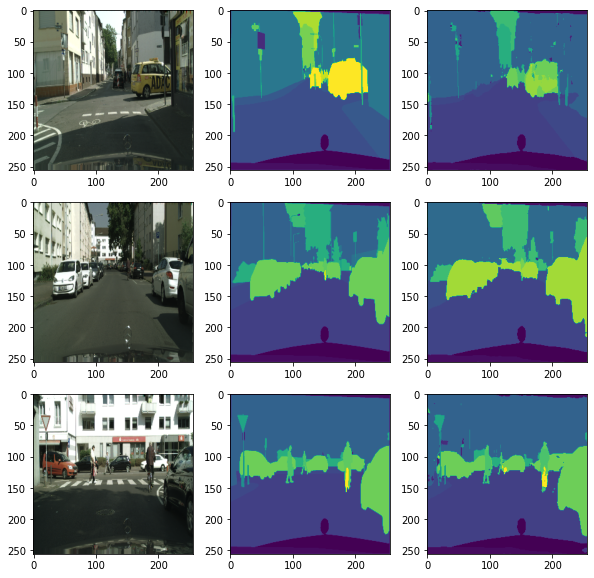

In [49]:
for image, mask in dataset_val.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

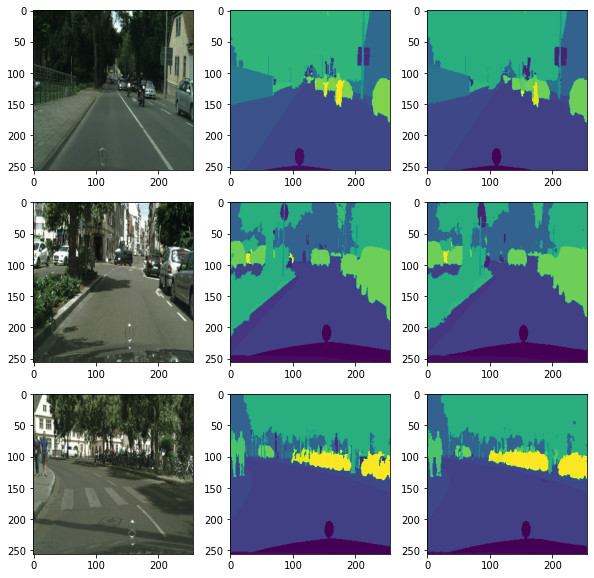

In [50]:
for image, mask in dataset_train.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

In [51]:
model.save('unet_v7.h5')